In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, when


# Initialisation de la session Spark, et charge les données Hive

In [2]:
spark = SparkSession.builder \
    .appName("DataCleaningWithHive") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()


In [3]:
spark.sql("USE concessionnaire")
df_client = spark.sql("SELECT * FROM client_data")

In [4]:

# zipWithIndex pour ajouter un index à chaque ligne, puis filtrer la première ligne
df_client = df_client.rdd.zipWithIndex().filter(lambda row_index: row_index[1] > 0).map(lambda row_index: row_index[0]).toDF(df_client.schema)


# Affichage des colonnes du df Client

In [5]:

# truncate=False : Empêche les colonnes d’être coupées si leur contenu est trop long.
df_client.show(n=10, truncate=False)


+---+----+----+-------------------+---------------+---------------+---------------+
|age|sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+----+----+-------------------+---------------+---------------+---------------+
|44 |M   |476 |En Couple          |0              |false          |3176 TS 67     |
|20 |M   |422 |En Couple          |2              |false          |3721 QS 49     |
|49 |F   |221 |C�libataire        |0              |false          |9099 UV 26     |
|57 |M   |246 |C�libataire        |0              |false          |3563 LA 55     |
|58 |M   |1149|C�libataire        |0              |false          |6963 AX 34     |
|36 |M   |228 |En Couple          |4              |false          |5592 HQ 89     |
|27 |M   |587 |C�libataire        |0              |false          |674 CE 26      |
|82 |F   |404 |C�libataire        |0              |false          |1756 PR 31     |
|53 |M   |530 |C�libataire        |0              |false          |6705 GX 5

# Traitement col age, taux, nbenfantacharge

In [6]:

# Liste des colonnes à traiter
colonnes_a_traiter = ["age", "taux", "nbenfantacharge"]

# Appliquer le traitement à chaque colonne
for colonne in colonnes_a_traiter:
    df_client = df_client.withColumn(
        colonne,
        when((col(colonne).isNull()) | (col(colonne) == "") | (col(colonne).contains("?")), None)  # Remplace null, vide, ? par None
        .when(col(colonne) < 0, None)  # Remplace les valeurs négatives par None
        .otherwise(col(colonne))  # Garde les autres valeurs
    )

# Supprimer les lignes où une des colonnes contient None après traitement
df_client = df_client.filter(
    ~(
        col("age").isNull() |
        col("taux").isNull() |
        col("nbenfantacharge").isNull()
    )
)

# Afficher le résultat après nettoyage
df_client.show(truncate=False)


+---+----+----+-------------------+---------------+---------------+---------------+
|age|sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+----+----+-------------------+---------------+---------------+---------------+
|44 |M   |476 |En Couple          |0              |false          |3176 TS 67     |
|20 |M   |422 |En Couple          |2              |false          |3721 QS 49     |
|49 |F   |221 |C�libataire        |0              |false          |9099 UV 26     |
|57 |M   |246 |C�libataire        |0              |false          |3563 LA 55     |
|58 |M   |1149|C�libataire        |0              |false          |6963 AX 34     |
|36 |M   |228 |En Couple          |4              |false          |5592 HQ 89     |
|27 |M   |587 |C�libataire        |0              |false          |674 CE 26      |
|82 |F   |404 |C�libataire        |0              |false          |1756 PR 31     |
|53 |M   |530 |C�libataire        |0              |false          |6705 GX 5

In [7]:
# Vérifier les lignes contenant des valeurs invalides restantes
df_client.filter(
    (col("age").isNull()) | (col("age") < 0) |
    (col("taux").isNull()) | (col("taux") < 0) |
    (col("nbenfantacharge").isNull()) | (col("nbenfantacharge") < 0)
).show()

+---+----+----+-------------------+---------------+---------------+---------------+
|age|sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+----+----+-------------------+---------------+---------------+---------------+
+---+----+----+-------------------+---------------+---------------+---------------+



# Traitement col situationfamiliale

In [8]:

# Affiche les valeurs uniques dans la colonne 'situationfamiliale'
df_client.select("situationfamilliale").distinct().show(truncate=False)


+-------------------+
|situationfamilliale|
+-------------------+
|Seul               |
|Mari�(e)           |
|Seule              |
|C�libataire        |
|N/D                |
|Divorc�e           |
|                   |
|En Couple          |
|?                  |
+-------------------+



In [9]:
# Remplace les caractères spéciaux par 'é' dans la colonne 'situationfamilliale'
df_client = df_client.withColumn("situationfamilliale", regexp_replace("situationfamilliale", "�", "é"))
df_client = df_client.withColumn("situationfamilliale", regexp_replace("situationfamilliale", "^(?i)seul(e)?$", "Célibataire"))
df_client = df_client.withColumn(
    "situationfamilliale",
    when((col("situationfamilliale").isin("N/D", "", " ","?")), "Inconnu")
    .otherwise(col("situationfamilliale")) 
)

In [10]:
df_client.select("situationfamilliale").distinct().show(truncate=False)


+-------------------+
|situationfamilliale|
+-------------------+
|Célibataire        |
|Divorcée           |
|Inconnu            |
|En Couple          |
|Marié(e)           |
+-------------------+



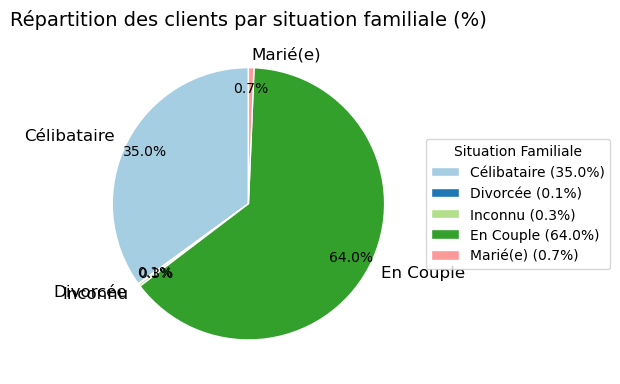

In [11]:
import matplotlib.pyplot as plt

# Étape 1 : Agréger les données et convertir en Pandas
situation_counts = df_client.groupBy("situationfamilliale").count()
situation_counts_pd = situation_counts.toPandas()

# Étape 2 : Calcul des pourcentages
total_count = situation_counts_pd["count"].sum()
situation_counts_pd["percentage"] = (situation_counts_pd["count"] / total_count) * 100

# Étape 3 : Création du diagramme circulaire
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    situation_counts_pd["percentage"],
    labels=situation_counts_pd["situationfamilliale"],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    pctdistance=0.85  # Ajuste la position des pourcentages
)

# Amélioration de la lisibilité
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color("black")

# Génération de labels avec pourcentages pour la légende
legend_labels = [f"{row['situationfamilliale']} ({row['percentage']:.1f}%)" for _, row in situation_counts_pd.iterrows()]

# Ajoute la légende avec les pourcentages
plt.legend(wedges, legend_labels, title="Situation Familiale", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Ajoute un titre
plt.title("Répartition des clients par situation familiale (%)", fontsize=14)

# Affiche le graphique
plt.tight_layout()
plt.show()


# Traitement col deuxiemevoiture

In [12]:
df_client.select("deuxiemevoiture").distinct().show(truncate=False)

+---------------+
|deuxiemevoiture|
+---------------+
|true           |
|false          |
|NULL           |
+---------------+



In [13]:
# Normaliser les valeurs de la colonne 'deuxiemevoiture' 
df_client = df_client.withColumn(
    "deuxiemevoiture",
    when((col("deuxiemevoiture") == "true"), "true") 
    .otherwise("false") # Si ce n'est pas "true", elle est définie comme "false".
)

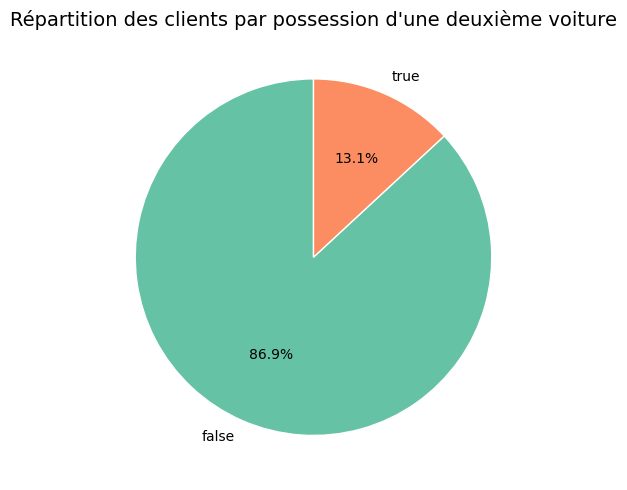

In [14]:
import matplotlib.pyplot as plt

# Étape 1 : Agréger les données et convertir en Pandas
deuxiemevoiture_counts = df_client.groupBy("deuxiemevoiture").count()
deuxiemevoiture_counts_pd = deuxiemevoiture_counts.toPandas()

# Étape 2 : Calcul des pourcentages
total_count = deuxiemevoiture_counts_pd["count"].sum()
deuxiemevoiture_counts_pd["percentage"] = (deuxiemevoiture_counts_pd["count"] / total_count) * 100

# Étape 3 : Création du diagramme circulaire
plt.figure(figsize=(5, 5))
plt.pie(
    deuxiemevoiture_counts_pd["percentage"],
    labels=deuxiemevoiture_counts_pd["deuxiemevoiture"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66c2a5", "#fc8d62"],  # Couleurs pour différencier "true" et "false"
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}  # Ligne blanche entre les sections
)

# Ajouter un titre
plt.title("Répartition des clients par possession d'une deuxième voiture", fontsize=14)

# Afficher le graphique
plt.tight_layout()
plt.show()


# Traitement col immatriculation

In [15]:
# Filtrer les lignes avec des valeurs manquantes dans la colonne 'immatriculation'
df_client = df_client.na.drop(subset=["immatriculation"])

# Traitement col sexe

In [16]:

# Compter les occurrences des valeurs dans la colonne sexe
sexe_distribution = df_client.groupBy("sexe").count()
sexe_distribution.show()


+--------+-----+
|    sexe|count|
+--------+-----+
|       F|28948|
|Masculin|  693|
|       M|67968|
|     N/D|   83|
|   Femme|  306|
| F�minin|  255|
|        |  117|
|   Homme|  664|
|       ?|  107|
+--------+-----+



In [17]:

# Normaliser les valeurs de la colonne 'sexe'
df_client = df_client.withColumn(
    "sexe",
    when(col("sexe").isin("M", "Masculin", "Homme"), "Homme")  
    .when(col("sexe").isin("F", "Femme", "Féminin", "F�minin"), "Femme")  
    .otherwise("Inconnu")  
)

# Filtrer pour supprimer les clients avec sexe 'Inconnu'
df_client = df_client.filter(col("sexe") != "Inconnu")

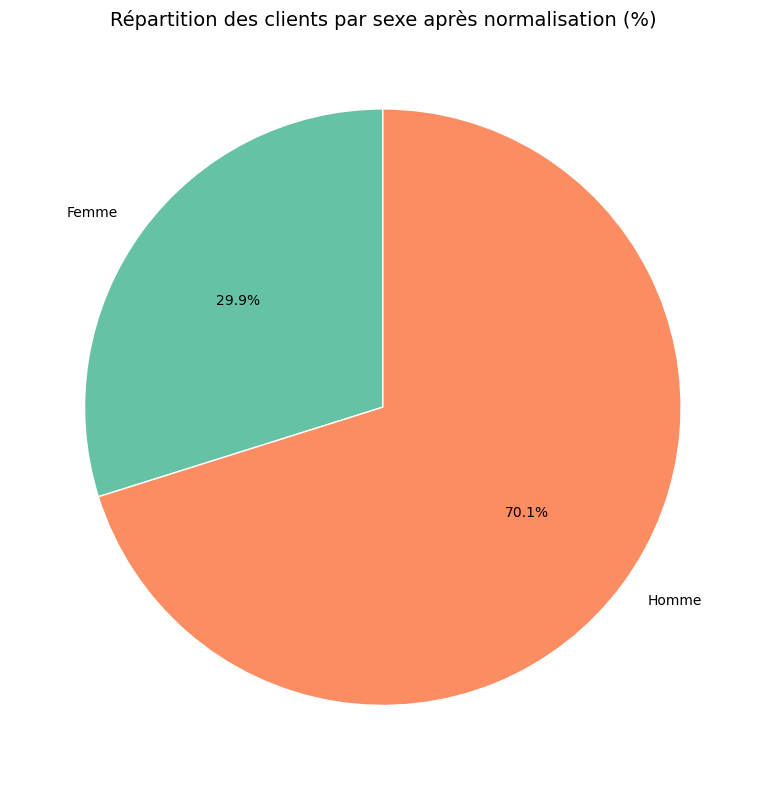

In [18]:

# Étape 2 : Compter les occurrences des valeurs dans la colonne 'sexe'
sexe_distribution = df_client.groupBy("sexe").count()
sexe_distribution_pd = sexe_distribution.toPandas()

# Étape 3 : Calcul des pourcentages
total_count = sexe_distribution_pd["count"].sum()
sexe_distribution_pd["percentage"] = (sexe_distribution_pd["count"] / total_count) * 100

# Étape 4 : Création du diagramme circulaire
plt.figure(figsize=(8, 8))
plt.pie(
    sexe_distribution_pd["percentage"],
    labels=sexe_distribution_pd["sexe"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66c2a5", "#fc8d62", "#8da0cb"],  # Couleurs pour "Homme", "Femme", et "Inconnu"
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}  # Bordure blanche pour séparer les sections
)

# Ajouter un titre
plt.title("Répartition des clients par sexe après normalisation (%)", fontsize=14)

# Afficher le graphique
plt.tight_layout()
plt.show()

In [19]:
df_client.show()

+---+-----+----+-------------------+---------------+---------------+---------------+
|age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|immatriculation|
+---+-----+----+-------------------+---------------+---------------+---------------+
| 44|Homme| 476|          En Couple|              0|          false|     3176 TS 67|
| 20|Homme| 422|          En Couple|              2|          false|     3721 QS 49|
| 49|Femme| 221|        Célibataire|              0|          false|     9099 UV 26|
| 57|Homme| 246|        Célibataire|              0|          false|     3563 LA 55|
| 58|Homme|1149|        Célibataire|              0|          false|     6963 AX 34|
| 36|Homme| 228|          En Couple|              4|          false|     5592 HQ 89|
| 27|Homme| 587|        Célibataire|              0|          false|      674 CE 26|
| 82|Femme| 404|        Célibataire|              0|          false|     1756 PR 31|
| 53|Homme| 530|        Célibataire|              0|          fal

In [20]:

# Étape 1 : Identifier les immatriculations en double
immatriculations_doubles = (
    df_client.groupBy("immatriculation")
    .count()
    .filter(col("count") > 1)  # Trouver les immatriculations ayant plus d'une occurrence
    .select("immatriculation")  # Conserver uniquement la colonne immatriculation
)

# Étape 2 : Filtrer les lignes complètes des clients ayant une immatriculation en double
clients_doubles = df_client.join(immatriculations_doubles, on="immatriculation", how="inner")

# Afficher les lignes complètes des clients en double
clients_doubles.show(truncate=False)


+---------------+---+-----+----+-------------------+---------------+---------------+
|immatriculation|age|sexe |taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|
+---------------+---+-----+----+-------------------+---------------+---------------+
|3491 UO 84     |43 |Homme|908 |En Couple          |4              |false          |
|3491 UO 84     |30 |Homme|1014|En Couple          |4              |true           |
|5064 CC 53     |64 |Femme|1353|En Couple          |3              |false          |
|5064 CC 53     |59 |Homme|404 |En Couple          |3              |true           |
|8166 CW 64     |24 |Femme|455 |En Couple          |0              |true           |
|8166 CW 64     |45 |Femme|191 |Célibataire        |1              |false          |
|1769 OU 76     |39 |Homme|416 |Célibataire        |0              |false          |
|1769 OU 76     |80 |Homme|207 |Célibataire        |0              |false          |
|7575 RU 54     |32 |Homme|593 |En Couple          |2            

In [21]:

# Exclure les clients avec des immatriculations en double
df_client_sans_doublons = df_client.join(immatriculations_doubles, on="immatriculation", how="left_anti")

# Afficher le résultat après suppression des doublons
df_client_sans_doublons.show(truncate=False)


+---------------+---+-----+----+-------------------+---------------+---------------+
|immatriculation|age|sexe |taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|
+---------------+---+-----+----+-------------------+---------------+---------------+
|3367 NG 10     |31 |Femme|441 |En Couple          |3              |false          |
|6414 XL 62     |19 |Femme|513 |En Couple          |0              |false          |
|6225 MG 76     |28 |Femme|425 |En Couple          |0              |false          |
|7333 AP 33     |39 |Femme|509 |En Couple          |2              |false          |
|9187 NT 91     |61 |Homme|168 |Célibataire        |0              |false          |
|530 KQ 46      |41 |Femme|556 |En Couple          |1              |false          |
|2434 PY 76     |43 |Homme|401 |En Couple          |2              |false          |
|7676 DT 25     |72 |Homme|533 |Célibataire        |0              |false          |
|5126 XE 11     |22 |Homme|1064|En Couple          |3            

In [22]:
df_client_sans_doublons.groupBy("immatriculation").count().filter(col("count") > 1).show()

+---------------+-----+
|immatriculation|count|
+---------------+-----+
+---------------+-----+



In [23]:
df_client.write.mode("overwrite").saveAsTable("client_processed")